## Assignment 3  

In this assignment, the wine.csv is used as dataset.  
Goal of current assignment is to use rule based learning techniques.  
Model performance is evaluated through accuracy, recall, precision and F1-score.  
Information about the data can be found [here](https://archive.ics.uci.edu/ml/datasets/wine)

In [1]:
import Orange
from Orange.classification.rules import LaplaceAccuracyEvaluator
import pandas as pd
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt

Data description

In [2]:
# load the data
data = Orange.data.Table("wine")

print(f'The dataset consists of {len(data)} observations.')

n_cont = sum(1 for a in data.domain.attributes if a.is_continuous)
n_disc = sum(1 for a in data.domain.attributes if a.is_discrete)
print(f'There are a total of {n_cont+n_disc} predictor variabes. {n_cont} of them are continuous and {n_disc} are discrete.') 

print('Attributes are:')
print('\n'.join([f'{i+1}: {data.domain.attributes[i].name}' for i in range(len(data.domain.attributes))]))

class_name = data.domain.class_var.name
print(f'\nClass to be predicted: {class_name}')
print(f'Values of class {class_name}: {",".join(data.domain[class_name].values)}')
count = Counter([str(d.get_class()) for d in data])
print('Each value appears:', ", ".join([f'{v}: {count[v]}' for v in data.domain[class_name].values]))


The dataset consists of 178 observations.
There are a total of 13 predictor variabes. 13 of them are continuous and 0 are discrete.
Attributes are:
1: Alcohol
2: Malic Acid
3: Ash
4: Alcalinity of ash
5: Magnesium
6: Total phenols
7: Flavanoids
8: Nonflavanoid phenols
9: Proanthocyanins
10: Color intensity
11: Hue
12: OD280/OD315 of diluted wines
13: Proline

Class to be predicted: Wine
Values of class Wine: 1,2,3
Each value appears: 1: 59, 2: 71, 3: 48


### Classification with induction rules

Induction of rules works by finding a rule that covers some learning instances, removing these instances, and repeating this until all instances are covered.  
The CN2 algorithm is a classification technique designed for the efficient induction of simple, comprehensible rules of form *“if condition then predict class”*, even in domains where noise may be present.  

As described [here](https://orange3.readthedocs.io/projects/orange-visual-programming/en/latest/index.html)

In [4]:
def grid_learners_results(data, beam_width_values, minimum_coverage_values, rule_length_values, ordering='Ordered', evaluator='default'):
    grid_combinations = []
    learners = []
    for bw, mc, rl in product(*[beam_width_values, minimum_coverage_values, rule_length_values]):
        grid_combinations += [(bw, mc, rl)]

        if ordering == 'Ordered':
            learner = Orange.classification.CN2Learner()
        elif ordering == 'Unordered':
            learner = Orange.classification.CN2UnorderedLearner()
        else:
            raise ValueError('Ordering of the learner must be one of "Ordered" or "Unordered".')

        if evaluator == 'default':
            pass
        elif evaluator == 'Laplace':
            learner.rule_finder.quality_evaluator = LaplaceAccuracyEvaluator()
        
        learner.rule_finder.search_strategy.constrain_continuous = True
        learner.rule_finder.search_algorithm.beam_width = bw
        learner.rule_finder.general_validator.min_covered_examples = mc
        learner.rule_finder.general_validator.max_rule_length = rl
        learners += [learner]

    # performing k-fold cross validation, results are calculated for a set of learners
    res = Orange.evaluation.CrossValidation(data, learners, k=5)

    accuracy = Orange.evaluation.scoring.CA(res)
    # since we have 3 classes (and not a typical binary classification)
    # precision, recall and f1 score are calculated by weighting the classes
    precision = Orange.evaluation.Precision(res, average='macro')
    recall = Orange.evaluation.Recall(res, average='macro')
    f1_score = Orange.evaluation.F1(res, average='macro')

    resultsDF = pd.DataFrame(data=grid_combinations, columns=['beam_width', 'min_cover','rule_len'])
    resultsDF['accuracy'] = accuracy
    resultsDF['precision'] = precision
    resultsDF['recall'] = recall
    resultsDF['f1_score'] = f1_score

    return resultsDF


In [13]:
def plot_metrics_over_coverage(beam_width, ordering, results):
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 8))
    fig.text(0.5, 0.08, 'Minimum Coverage', horizontalalignment='center', fontsize=12)
    fig.text(0.5, 0.95, f'Evaluation metrics for different maximum rule length cobinations \nfor {beam_width} solution streams considered at a time for {ordering} learner', horizontalalignment='center', fontsize=14)

    for r in results['rule_len'].unique():
        for i, score in zip([1,2,3,4],['accuracy', 'precision', 'recall', 'f1_score']):
            plt.subplot(2,2,i)
            subset = results[results['rule_len'] == r]
            plt.plot(subset.loc[subset['beam_width']==beam_width,'min_cover'].tolist(), 
                     subset.loc[subset['beam_width']==beam_width, score].tolist(), label=r, alpha=0.5)
            plt.legend(loc='upper left')
            plt.title(score.capitalize())

In [46]:
def rule_and_metrics(data, results, best_results=True, ordering='Ordered', evaluator='default'):
    if ordering == 'Ordered':
        learner = Orange.classification.CN2Learner()
    elif ordering == 'Unordered':
        learner = Orange.classification.CN2UnorderedLearner()
    else:
        raise ValueError('Ordering of the learner must be one of "Ordered" or "Unordered".')

    if evaluator == 'default':
        pass
    elif evaluator == 'Laplace':
        learner.rule_finder.quality_evaluator = LaplaceAccuracyEvaluator()

    if best_results:
        f1 = results.sort_values(by='f1_score', ascending=False)['f1_score'].tolist()[0]
    else:
        f1 = results.sort_values(by='f1_score', ascending=True)['f1_score'].tolist()[0]
    parameters = results.loc[results['f1_score']==f1,:].iloc[0]

    learner.rule_finder.search_strategy.constrain_continuous = True
    learner.rule_finder.search_algorithm.beam_width = int(parameters['beam_width'])
    learner.rule_finder.general_validator.min_covered_examples = int(parameters['min_cover'])
    learner.rule_finder.general_validator.max_rule_length = int(parameters['rule_len'])

    classifier = learner(data)
    
    print(f'The model is trained with the following hyper-parameteres: \nBeam Width:       {int(parameters["beam_width"])} \nMinimum Coverage: {int(parameters["min_cover"])} \nMax Rule Length:  {int(parameters["rule_len"])}')

    print(f'\nMetrics for the model \nAccuracy:   {parameters["accuracy"]} \nPrecision:  {parameters["precision"]} \nRecall:     {parameters["recall"]} \nF1_score:   {parameters["f1_score"]}')
    print('\nRules')
    print('\n'.join([str(rule) for rule in classifier.rule_list]))


### Unordered learner 

An unordered CN2 lerner induces unordered rules (rule sets). Learns rules for each class individually, in regard to the original learning data.  

Varying values of beam width (how many solution streams to consider at a time), minimum rule coverage (minimum amount of examples that need to be covered by each rule) and maximum rule length (maximum amount of selectors (conditions) that can be combined for a rule)

Grid search reasults to tune the hyper parameters of the model.  
We assume that the best model is the model with the highest F1 score.  
*Many parameter combinations had the same f1 score, and for that score accuracy, precision and recall are the same, so I proceeded into choosing the "simplest" model with those scores.*

In [8]:
grid = {'beam_width':range(2,11), 'min_cover':range(8,31,2), 'rule_len':range(2,6)}

resultsDF = grid_learners_results(data=data, ordering='Unordered', beam_width_values=grid['beam_width'], 
                                  minimum_coverage_values=grid['min_cover'], rule_length_values=grid['rule_len'])

In [9]:
f1 = resultsDF.sort_values(by='f1_score', ascending=False)['f1_score'].tolist()[0]
resultsDF.loc[resultsDF['f1_score']==f1,:].head()

,beam_width,min_cover,rule_len,accuracy,precision,recall,f1_score
333,8,30,3,0.904494,0.916006,0.898711,0.90539
334,8,30,4,0.904494,0.916006,0.898711,0.90539
335,8,30,5,0.904494,0.916006,0.898711,0.90539
369,9,24,3,0.904494,0.916006,0.898711,0.90539
370,9,24,4,0.904494,0.916006,0.898711,0.90539


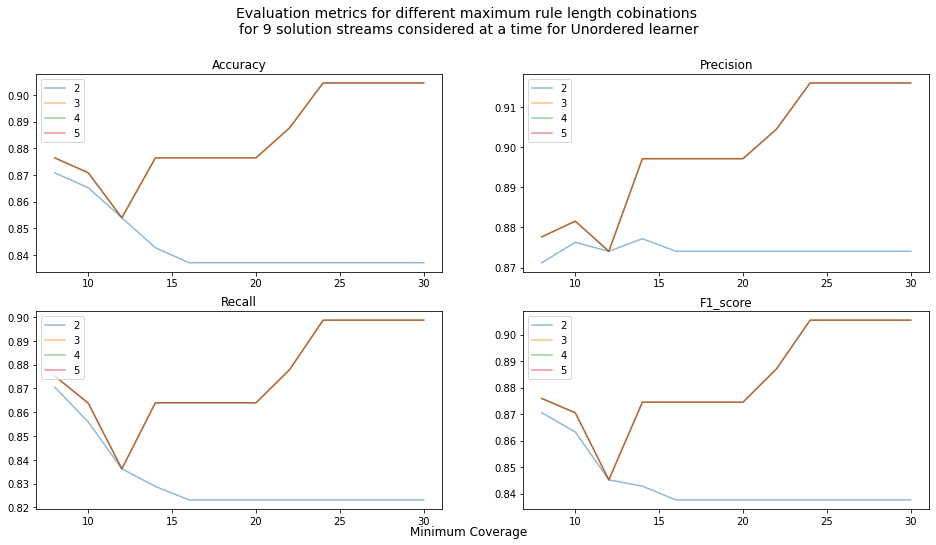

In [15]:
plot_metrics_over_coverage(beam_width=9, ordering='Unordered', results=resultsDF)

In [48]:
rule_and_metrics(data=data, results=resultsDF, best_results=True, ordering='Unordered')

The model is trained with the following hyper-parameteres: 
Beam Width:       8 
Minimum Coverage: 30 
Max Rule Length:  3

Metrics for the model 
Accuracy:   0.9044943820224719 
Precision:  0.9160060697814597 
Recall:     0.8987112410811383 
F1_score:   0.9053904549556724

Rules
IF Proline>=990.0 THEN Wine=1 
IF Alcohol<=12.79 AND OD280/OD315 of diluted wines>=2.06 THEN Wine=2 
IF Flavanoids<=1.58 AND Color intensity>=3.85 AND Ash>=2.1 THEN Wine=3 
IF TRUE THEN Wine=2 


In [49]:
rule_and_metrics(data=data, results=resultsDF, best_results=False, ordering='Unordered')

The model is trained with the following hyper-parameteres: 
Beam Width:       2 
Minimum Coverage: 14 
Max Rule Length:  3

Metrics for the model 
Accuracy:   0.7865168539325843 
Precision:  0.7840834964122635 
Recall:     0.7779634492453781 
F1_score:   0.7796144505160899

Rules
IF Proline>=990.0 THEN Wine=1 
IF Proline>=735.0 AND Flavanoids>=2.41 THEN Wine=1 
IF Color intensity<=3.52 AND Nonflavanoid phenols>=0.29 THEN Wine=2 
IF Alcohol<=12.85 AND OD280/OD315 of diluted wines>=2.26 AND Alcalinity of ash>=18.0 THEN Wine=2 
IF Flavanoids<=0.99 AND Color intensity>=3.85 THEN Wine=3 
IF TRUE THEN Wine=2 


### Ordered learner with Entropy evaluator

In [50]:
resultsOrderedDF = grid_learners_results(data=data, ordering='Ordered', beam_width_values=grid['beam_width'], 
                                  minimum_coverage_values=grid['min_cover'], rule_length_values=grid['rule_len'])

In [51]:
f1 = resultsOrderedDF.sort_values(by='f1_score', ascending=False)['f1_score'].tolist()[0]
resultsOrderedDF.loc[resultsOrderedDF['f1_score']==f1,:].head()

,beam_width,min_cover,rule_len,accuracy,precision,recall,f1_score
0,2,8,2,0.926966,0.932408,0.925194,0.928338
1,2,8,3,0.926966,0.932408,0.925194,0.928338
2,2,8,4,0.926966,0.932408,0.925194,0.928338
3,2,8,5,0.926966,0.932408,0.925194,0.928338


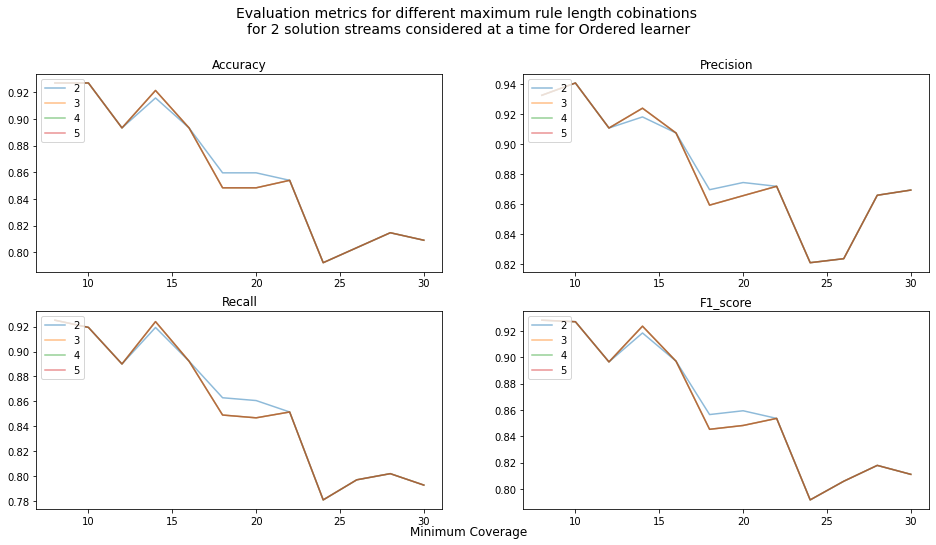

In [52]:
plot_metrics_over_coverage(beam_width=2, ordering='Ordered', results=resultsOrderedDF)

In [54]:
rule_and_metrics(data=data, results=resultsOrderedDF, best_results=True, ordering='Ordered')
print('\n***********************\n')
rule_and_metrics(data=data, results=resultsOrderedDF, best_results=False, ordering='Ordered')


The model is trained with the following hyper-parameteres: 
Beam Width:       2 
Minimum Coverage: 8 
Max Rule Length:  2

Metrics for the model 
Accuracy:   0.9269662921348315 
Precision:  0.9324078311721333 
Recall:     0.9251942919285959 
F1_score:   0.9283376382342201

Rules
IF Hue>=1.31 THEN Wine=2 
IF Proline>=970.0 THEN Wine=1 
IF Color intensity>=6.62 THEN Wine=3 
IF Proline<=510.0 AND Alcalinity of ash>=20.7 THEN Wine=2 
IF Color intensity<=3.52 AND Nonflavanoid phenols>=0.29 THEN Wine=2 
IF Ash<=2.1 AND Hue>=0.98 THEN Wine=2 
IF OD280/OD315 of diluted wines>=3.35 THEN Wine=1 
IF Color intensity>=4.9 THEN Wine=3 
IF Alcohol<=12.86 AND Total phenols>=1.6 THEN Wine=2 
IF Magnesium>=89.0 AND Alcalinity of ash>=18.0 THEN Wine=3 
IF TRUE THEN Wine=2 

***********************

The model is trained with the following hyper-parameteres: 
Beam Width:       2 
Minimum Coverage: 24 
Max Rule Length:  2

Metrics for the model 
Accuracy:   0.7921348314606742 
Precision:  0.8210687894355223

### Ordered classifier with Laplace evaluator

In [55]:
resultsOrderedLaplaceDF = grid_learners_results(data=data, ordering='Ordered', beam_width_values=grid['beam_width'], 
                                  minimum_coverage_values=grid['min_cover'], rule_length_values=grid['rule_len'], evaluator='Laplace')

In [56]:
f1 = resultsOrderedLaplaceDF.sort_values(by='f1_score', ascending=False)['f1_score'].tolist()[0]
resultsOrderedLaplaceDF.loc[resultsOrderedLaplaceDF['f1_score']==f1,:].head()

,beam_width,min_cover,rule_len,accuracy,precision,recall,f1_score
260,7,18,2,0.898876,0.900169,0.891427,0.894718


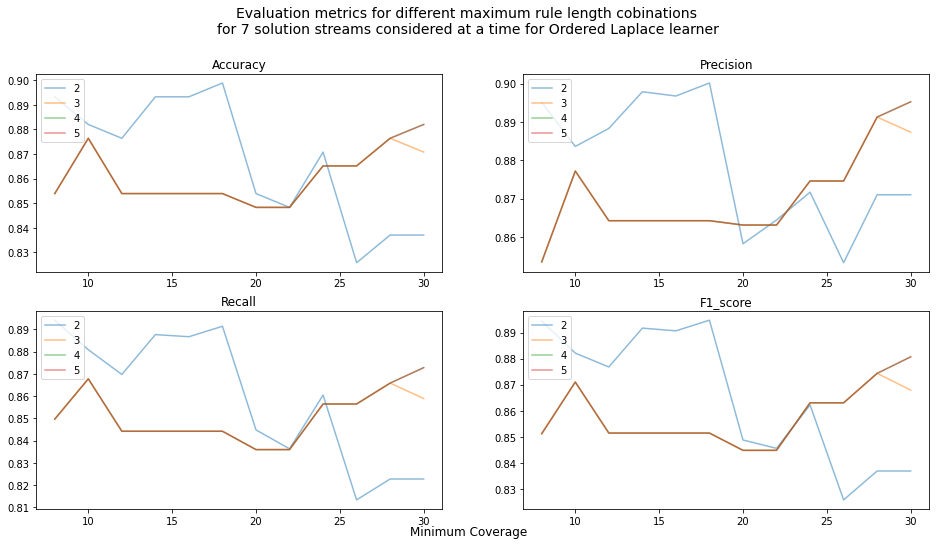

In [57]:
plot_metrics_over_coverage(beam_width=7, ordering='Ordered Laplace', results=resultsOrderedLaplaceDF)

In [58]:
rule_and_metrics(data=data, results=resultsOrderedLaplaceDF, best_results=True, ordering='Ordered', evaluator='Laplace')
print('\n***********************\n')
rule_and_metrics(data=data, results=resultsOrderedLaplaceDF, best_results=False, ordering='Ordered', evaluator='Laplace')

The model is trained with the following hyper-parameteres: 
Beam Width:       7 
Minimum Coverage: 18 
Max Rule Length:  2

Metrics for the model 
Accuracy:   0.898876404494382 
Precision:  0.9001693267800778 
Recall:     0.8914269515397469 
F1_score:   0.8947181171319102

Rules
IF Proline>=990.0 THEN Wine=1 
IF Flavanoids<=0.99 AND Color intensity>=3.85 THEN Wine=3 
IF Alcohol<=12.79 AND OD280/OD315 of diluted wines>=1.59 THEN Wine=2 
IF Flavanoids>=2.41 AND Hue<=1.31 THEN Wine=1 
IF TRUE THEN Wine=2 

***********************

The model is trained with the following hyper-parameteres: 
Beam Width:       4 
Minimum Coverage: 30 
Max Rule Length:  4

Metrics for the model 
Accuracy:   0.8146067415730337 
Precision:  0.8442922112665291 
Recall:     0.8034120447733483 
F1_score:   0.8157687991021324

Rules
IF Proline>=990.0 THEN Wine=1 
IF Color intensity<=3.85 AND Color intensity<=3.52 AND Nonflavanoid phenols>=0.29 THEN Wine=2 
IF Hue<=0.9 AND Flavanoids<=1.59 AND Magnesium>=86.0 THEN W